In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_roi_t1_normalized_k5_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 276)
(734160, 1)
validation
(101248, 276)
(101248, 1)
test
(100432, 276)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 276)]             0         


 dense (Dense)               (None, 1024)              283648    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 972801 (3.71 MB)


Trainable params: 972801 (3.71 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:48 - loss: 0.0650 - STD: 1.3199e-04 - MAE: 0.2389

 5/74 [=>............................] - ETA: 1s - loss: 0.0255 - STD: 1.1480e-04 - MAE: 0.1249  

 9/74 [==>...........................] - ETA: 0s - loss: 0.0247 - STD: 8.4019e-05 - MAE: 0.1236

13/74 [====>.........................] - ETA: 0s - loss: 0.0221 - STD: 6.6835e-05 - MAE: 0.1151

17/74 [=====>........................] - ETA: 0s - loss: 0.0192 - STD: 5.8158e-05 - MAE: 0.1063

21/74 [=======>......................] - ETA: 0s - loss: 0.0179 - STD: 5.3859e-05 - MAE: 0.1041

25/74 [=========>....................] - ETA: 0s - loss: 0.0166 - STD: 5.0912e-05 - MAE: 0.1005

29/74 [==========>...................] - ETA: 0s - loss: 0.0157 - STD: 4.8387e-05 - MAE: 0.0969

33/74 [============>.................] - ETA: 0s - loss: 0.0150 - STD: 4.6681e-05 - MAE: 0.0942

37/74 [==============>...............] - ETA: 0s - loss: 0.0144 - STD: 4.6012e-05 - MAE: 0.0921

41/74 [===============>..............] - ETA: 0s - loss: 0.0140 - STD: 4.6145e-05 - MAE: 0.0908

45/74 [=================>............] - ETA: 0s - loss: 0.0136 - STD: 4.6633e-05 - MAE: 0.0897

49/74 [==================>...........] - ETA: 0s - loss: 0.0132 - STD: 4.7271e-05 - MAE: 0.0885

53/74 [====================>.........] - ETA: 0s - loss: 0.0129 - STD: 4.8066e-05 - MAE: 0.0874

55/74 [=====================>........] - ETA: 0s - loss: 0.0128 - STD: 4.8572e-05 - MAE: 0.0869

59/74 [======================>.......] - ETA: 0s - loss: 0.0126 - STD: 4.9892e-05 - MAE: 0.0862

63/74 [========================>.....] - ETA: 0s - loss: 0.0124 - STD: 5.1415e-05 - MAE: 0.0856

67/74 [==========================>...] - ETA: 0s - loss: 0.0122 - STD: 5.3113e-05 - MAE: 0.0850

71/74 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 5.4928e-05 - MAE: 0.0844

74/74 [==============================] - 4s 35ms/step - loss: 0.0119 - STD: 5.6365e-05 - MAE: 0.0841 - val_loss: 0.0086 - val_STD: 7.3772e-05 - val_MAE: 0.0715


Epoch 2/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0090 - STD: 9.3795e-05 - MAE: 0.0744

 5/74 [=>............................] - ETA: 1s - loss: 0.0092 - STD: 9.8922e-05 - MAE: 0.0755

 9/74 [==>...........................] - ETA: 0s - loss: 0.0092 - STD: 1.0233e-04 - MAE: 0.0757

13/74 [====>.........................] - ETA: 0s - loss: 0.0092 - STD: 1.0587e-04 - MAE: 0.0755

17/74 [=====>........................] - ETA: 0s - loss: 0.0093 - STD: 1.1009e-04 - MAE: 0.0756

21/74 [=======>......................] - ETA: 0s - loss: 0.0093 - STD: 1.1450e-04 - MAE: 0.0756

25/74 [=========>....................] - ETA: 0s - loss: 0.0092 - STD: 1.1887e-04 - MAE: 0.0756

29/74 [==========>...................] - ETA: 0s - loss: 0.0092 - STD: 1.2350e-04 - MAE: 0.0755

33/74 [============>.................] - ETA: 0s - loss: 0.0092 - STD: 1.2822e-04 - MAE: 0.0755

37/74 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 1.3322e-04 - MAE: 0.0755

41/74 [===============>..............] - ETA: 0s - loss: 0.0092 - STD: 1.3835e-04 - MAE: 0.0755

45/74 [=================>............] - ETA: 0s - loss: 0.0092 - STD: 1.4378e-04 - MAE: 0.0754

49/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 1.4944e-04 - MAE: 0.0754

53/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 1.5543e-04 - MAE: 0.0754

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.6175e-04 - MAE: 0.0754

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.6840e-04 - MAE: 0.0754

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.7537e-04 - MAE: 0.0754

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.8266e-04 - MAE: 0.0754

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.9037e-04 - MAE: 0.0754

74/74 [==============================] - 1s 17ms/step - loss: 0.0092 - STD: 1.9247e-04 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 2.7208e-04 - val_MAE: 0.0716


Epoch 3/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0092 - STD: 3.4608e-04 - MAE: 0.0755

 5/74 [=>............................] - ETA: 1s - loss: 0.0092 - STD: 3.6181e-04 - MAE: 0.0755

 9/74 [==>...........................] - ETA: 0s - loss: 0.0092 - STD: 3.7615e-04 - MAE: 0.0754

12/74 [===>..........................] - ETA: 0s - loss: 0.0092 - STD: 3.8714e-04 - MAE: 0.0753

16/74 [=====>........................] - ETA: 0s - loss: 0.0092 - STD: 4.0226e-04 - MAE: 0.0754

20/74 [=======>......................] - ETA: 0s - loss: 0.0092 - STD: 4.2012e-04 - MAE: 0.0754

24/74 [========>.....................] - ETA: 0s - loss: 0.0092 - STD: 4.3831e-04 - MAE: 0.0754

28/74 [==========>...................] - ETA: 0s - loss: 0.0092 - STD: 4.5759e-04 - MAE: 0.0755

32/74 [===========>..................] - ETA: 0s - loss: 0.0092 - STD: 4.8008e-04 - MAE: 0.0755

36/74 [=============>................] - ETA: 0s - loss: 0.0092 - STD: 5.0420e-04 - MAE: 0.0755

40/74 [===============>..............] - ETA: 0s - loss: 0.0092 - STD: 5.3024e-04 - MAE: 0.0755

43/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 5.5134e-04 - MAE: 0.0754

47/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 5.8250e-04 - MAE: 0.0753

51/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 6.1557e-04 - MAE: 0.0753

55/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 6.5348e-04 - MAE: 0.0752

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 6.9538e-04 - MAE: 0.0753

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 7.4103e-04 - MAE: 0.0752

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 7.9132e-04 - MAE: 0.0752

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 8.5041e-04 - MAE: 0.0752

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 8.9970e-04 - MAE: 0.0752

74/74 [==============================] - 1s 17ms/step - loss: 0.0092 - STD: 8.9970e-04 - MAE: 0.0752 - val_loss: 0.0085 - val_STD: 0.0017 - val_MAE: 0.0709


Epoch 4/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0092 - STD: 0.0022 - MAE: 0.0751

 5/74 [=>............................] - ETA: 1s - loss: 0.0090 - STD: 0.0024 - MAE: 0.0745

 9/74 [==>...........................] - ETA: 1s - loss: 0.0091 - STD: 0.0025 - MAE: 0.0748

13/74 [====>.........................] - ETA: 0s - loss: 0.0090 - STD: 0.0028 - MAE: 0.0749

17/74 [=====>........................] - ETA: 0s - loss: 0.0090 - STD: 0.0030 - MAE: 0.0747

21/74 [=======>......................] - ETA: 0s - loss: 0.0090 - STD: 0.0033 - MAE: 0.0747

24/74 [========>.....................] - ETA: 0s - loss: 0.0090 - STD: 0.0036 - MAE: 0.0748

28/74 [==========>...................] - ETA: 0s - loss: 0.0090 - STD: 0.0039 - MAE: 0.0746

32/74 [===========>..................] - ETA: 0s - loss: 0.0089 - STD: 0.0044 - MAE: 0.0745

36/74 [=============>................] - ETA: 0s - loss: 0.0089 - STD: 0.0049 - MAE: 0.0744

40/74 [===============>..............] - ETA: 0s - loss: 0.0089 - STD: 0.0055 - MAE: 0.0742

44/74 [================>.............] - ETA: 0s - loss: 0.0088 - STD: 0.0062 - MAE: 0.0741

48/74 [==================>...........] - ETA: 0s - loss: 0.0088 - STD: 0.0069 - MAE: 0.0739

52/74 [====================>.........] - ETA: 0s - loss: 0.0087 - STD: 0.0078 - MAE: 0.0738

56/74 [=====================>........] - ETA: 0s - loss: 0.0087 - STD: 0.0088 - MAE: 0.0736

60/74 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 0.0098 - MAE: 0.0734

64/74 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 0.0109 - MAE: 0.0733

68/74 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 0.0120 - MAE: 0.0731

72/74 [============================>.] - ETA: 0s - loss: 0.0085 - STD: 0.0131 - MAE: 0.0729

74/74 [==============================] - 1s 17ms/step - loss: 0.0085 - STD: 0.0136 - MAE: 0.0728 - val_loss: 0.0071 - val_STD: 0.0247 - val_MAE: 0.0634


Epoch 5/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0078 - STD: 0.0334 - MAE: 0.0690

 5/74 [=>............................] - ETA: 1s - loss: 0.0075 - STD: 0.0340 - MAE: 0.0683

 9/74 [==>...........................] - ETA: 0s - loss: 0.0074 - STD: 0.0347 - MAE: 0.0679

13/74 [====>.........................] - ETA: 0s - loss: 0.0073 - STD: 0.0353 - MAE: 0.0674

17/74 [=====>........................] - ETA: 0s - loss: 0.0072 - STD: 0.0359 - MAE: 0.0670

21/74 [=======>......................] - ETA: 0s - loss: 0.0072 - STD: 0.0365 - MAE: 0.0666

25/74 [=========>....................] - ETA: 0s - loss: 0.0071 - STD: 0.0373 - MAE: 0.0662

29/74 [==========>...................] - ETA: 0s - loss: 0.0070 - STD: 0.0382 - MAE: 0.0658

33/74 [============>.................] - ETA: 0s - loss: 0.0070 - STD: 0.0391 - MAE: 0.0654

37/74 [==============>...............] - ETA: 0s - loss: 0.0069 - STD: 0.0402 - MAE: 0.0651

41/74 [===============>..............] - ETA: 0s - loss: 0.0069 - STD: 0.0412 - MAE: 0.0648

45/74 [=================>............] - ETA: 0s - loss: 0.0068 - STD: 0.0422 - MAE: 0.0645

49/74 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.0431 - MAE: 0.0642

53/74 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0439 - MAE: 0.0640

56/74 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0444 - MAE: 0.0638

60/74 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0451 - MAE: 0.0637

64/74 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0457 - MAE: 0.0635

68/74 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0461 - MAE: 0.0633

72/74 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0465 - MAE: 0.0632

74/74 [==============================] - 1s 17ms/step - loss: 0.0066 - STD: 0.0468 - MAE: 0.0631 - val_loss: 0.0058 - val_STD: 0.0353 - val_MAE: 0.0549


Epoch 6/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0065 - STD: 0.0519 - MAE: 0.0608

 5/74 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0532 - MAE: 0.0601

 8/74 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0535 - MAE: 0.0599

12/74 [===>..........................] - ETA: 0s - loss: 0.0061 - STD: 0.0537 - MAE: 0.0600

16/74 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0540 - MAE: 0.0602

20/74 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0542 - MAE: 0.0602

24/74 [========>.....................] - ETA: 0s - loss: 0.0061 - STD: 0.0544 - MAE: 0.0602

28/74 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0545 - MAE: 0.0602

32/74 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0545 - MAE: 0.0601

36/74 [=============>................] - ETA: 0s - loss: 0.0061 - STD: 0.0547 - MAE: 0.0600

40/74 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0548 - MAE: 0.0600

44/74 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0599

48/74 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0599

52/74 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0599

56/74 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0551 - MAE: 0.0598

60/74 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0551 - MAE: 0.0598

64/74 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0552 - MAE: 0.0598

68/74 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0553 - MAE: 0.0597

72/74 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0554 - MAE: 0.0597

74/74 [==============================] - 1s 17ms/step - loss: 0.0060 - STD: 0.0554 - MAE: 0.0597 - val_loss: 0.0053 - val_STD: 0.0398 - val_MAE: 0.0533


Epoch 7/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0592

 4/74 [>.............................] - ETA: 1s - loss: 0.0060 - STD: 0.0565 - MAE: 0.0591

 8/74 [==>...........................] - ETA: 1s - loss: 0.0059 - STD: 0.0565 - MAE: 0.0589

11/74 [===>..........................] - ETA: 1s - loss: 0.0059 - STD: 0.0566 - MAE: 0.0588

15/74 [=====>........................] - ETA: 0s - loss: 0.0059 - STD: 0.0569 - MAE: 0.0589

18/74 [======>.......................] - ETA: 0s - loss: 0.0059 - STD: 0.0569 - MAE: 0.0588

22/74 [=======>......................] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0589

25/74 [=========>....................] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0588

29/74 [==========>...................] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0589

33/74 [============>.................] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0588

37/74 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0588

41/74 [===============>..............] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0589

45/74 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0569 - MAE: 0.0589

49/74 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0569 - MAE: 0.0589

53/74 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0568 - MAE: 0.0589

57/74 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0568 - MAE: 0.0589

61/74 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0568 - MAE: 0.0589

65/74 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0567 - MAE: 0.0589

68/74 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0567 - MAE: 0.0589

72/74 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0567 - MAE: 0.0589

74/74 [==============================] - 1s 17ms/step - loss: 0.0059 - STD: 0.0567 - MAE: 0.0589 - val_loss: 0.0053 - val_STD: 0.0409 - val_MAE: 0.0530


Epoch 8/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0567 - MAE: 0.0574

 5/74 [=>............................] - ETA: 1s - loss: 0.0058 - STD: 0.0572 - MAE: 0.0582

 9/74 [==>...........................] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0586

13/74 [====>.........................] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0585

17/74 [=====>........................] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0583

21/74 [=======>......................] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0583

25/74 [=========>....................] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0583

29/74 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0583

33/74 [============>.................] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0583

37/74 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0583

41/74 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0583

45/74 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0583

49/74 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0583

53/74 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0582

58/74 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0582

62/74 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0582

66/74 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0582

70/74 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0582

74/74 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0582

74/74 [==============================] - 1s 17ms/step - loss: 0.0058 - STD: 0.0577 - MAE: 0.0582 - val_loss: 0.0052 - val_STD: 0.0423 - val_MAE: 0.0527


Epoch 9/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0570 - MAE: 0.0574

 5/74 [=>............................] - ETA: 1s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0578

 9/74 [==>...........................] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0577

12/74 [===>..........................] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0576

16/74 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0578

20/74 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0578

24/74 [========>.....................] - ETA: 0s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0579

28/74 [==========>...................] - ETA: 0s - loss: 0.0057 - STD: 0.0580 - MAE: 0.0579

32/74 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0580 - MAE: 0.0579

36/74 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0580 - MAE: 0.0578

40/74 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0578

44/74 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0578

48/74 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0577

52/74 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0577

55/74 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0576

59/74 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0577

62/74 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0577

66/74 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0578

70/74 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0579

74/74 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0578 - MAE: 0.0579

74/74 [==============================] - 1s 17ms/step - loss: 0.0057 - STD: 0.0578 - MAE: 0.0579 - val_loss: 0.0050 - val_STD: 0.0431 - val_MAE: 0.0530


Epoch 10/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0554 - MAE: 0.0584

 5/74 [=>............................] - ETA: 1s - loss: 0.0058 - STD: 0.0559 - MAE: 0.0587

 9/74 [==>...........................] - ETA: 0s - loss: 0.0057 - STD: 0.0568 - MAE: 0.0581

13/74 [====>.........................] - ETA: 0s - loss: 0.0057 - STD: 0.0576 - MAE: 0.0578

17/74 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0578 - MAE: 0.0577

21/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0579 - MAE: 0.0576

25/74 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0579 - MAE: 0.0575

29/74 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0580 - MAE: 0.0575

33/74 [============>.................] - ETA: 0s - loss: 0.0056 - STD: 0.0582 - MAE: 0.0575

37/74 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0583 - MAE: 0.0576

41/74 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0583 - MAE: 0.0576

45/74 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0583 - MAE: 0.0575

49/74 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0583 - MAE: 0.0575

53/74 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0585 - MAE: 0.0575

57/74 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0586 - MAE: 0.0575

61/74 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0575

65/74 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0574

69/74 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0574

73/74 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0573

74/74 [==============================] - 1s 16ms/step - loss: 0.0056 - STD: 0.0588 - MAE: 0.0573 - val_loss: 0.0051 - val_STD: 0.0466 - val_MAE: 0.0522


Epoch 11/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0567

 5/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0590 - MAE: 0.0567

 9/74 [==>...........................] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0569

13/74 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0571

17/74 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0595 - MAE: 0.0569

21/74 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0594 - MAE: 0.0569

25/74 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0595 - MAE: 0.0569

29/74 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0595 - MAE: 0.0568

33/74 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0595 - MAE: 0.0568

37/74 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0595 - MAE: 0.0568

41/74 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0595 - MAE: 0.0568

45/74 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0596 - MAE: 0.0568

49/74 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0597 - MAE: 0.0567

53/74 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0598 - MAE: 0.0568

57/74 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0598 - MAE: 0.0568

61/74 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0598 - MAE: 0.0568

66/74 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0598 - MAE: 0.0568

70/74 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0598 - MAE: 0.0569

74/74 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0597 - MAE: 0.0569

74/74 [==============================] - 1s 15ms/step - loss: 0.0055 - STD: 0.0597 - MAE: 0.0569 - val_loss: 0.0053 - val_STD: 0.0455 - val_MAE: 0.0523


Epoch 12/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0560 - MAE: 0.0556

 5/74 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0578 - MAE: 0.0577

 9/74 [==>...........................] - ETA: 0s - loss: 0.0056 - STD: 0.0583 - MAE: 0.0575

13/74 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0585 - MAE: 0.0574

17/74 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0585 - MAE: 0.0572

21/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0573

25/74 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0588 - MAE: 0.0574

30/74 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0588 - MAE: 0.0572

34/74 [============>.................] - ETA: 0s - loss: 0.0056 - STD: 0.0590 - MAE: 0.0572

38/74 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0572

42/74 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0572

46/74 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0571

50/74 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0571

54/74 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0570

58/74 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0595 - MAE: 0.0570

62/74 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0595 - MAE: 0.0569

66/74 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0596 - MAE: 0.0569

70/74 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0597 - MAE: 0.0569

74/74 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0598 - MAE: 0.0569

74/74 [==============================] - 1s 15ms/step - loss: 0.0055 - STD: 0.0598 - MAE: 0.0569 - val_loss: 0.0048 - val_STD: 0.0506 - val_MAE: 0.0521


Epoch 13/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0568

 5/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0567

 9/74 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0567

13/74 [====>.........................] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0567

17/74 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0565

21/74 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0564

25/74 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0565

30/74 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0564

34/74 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0565

38/74 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0565

42/74 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0565

46/74 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0565

50/74 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0565

54/74 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0565

58/74 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0564

62/74 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0565

66/74 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0564

70/74 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0564

74/74 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0564

74/74 [==============================] - 1s 15ms/step - loss: 0.0055 - STD: 0.0607 - MAE: 0.0564 - val_loss: 0.0049 - val_STD: 0.0513 - val_MAE: 0.0520


Epoch 14/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0631 - MAE: 0.0565

 5/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0564

 9/74 [==>...........................] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0564

13/74 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0565

18/74 [======>.......................] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0565

22/74 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0567

26/74 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0567

30/74 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0601 - MAE: 0.0566

34/74 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0603 - MAE: 0.0566

38/74 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0565

42/74 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0565

46/74 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0565

50/74 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0565

54/74 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0565

58/74 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0565

62/74 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0565

66/74 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0566

70/74 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0565

74/74 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0566

74/74 [==============================] - 1s 15ms/step - loss: 0.0055 - STD: 0.0607 - MAE: 0.0566 - val_loss: 0.0048 - val_STD: 0.0511 - val_MAE: 0.0522


Epoch 15/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0572

 5/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0567

 9/74 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0567

13/74 [====>.........................] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0566

17/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0564

21/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0564

25/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0564

29/74 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0564

33/74 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0563

37/74 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0563

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0563

45/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0563

49/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0563

53/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0563

57/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0563

61/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0563

65/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0563

70/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0562

74/74 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0563

74/74 [==============================] - 1s 15ms/step - loss: 0.0054 - STD: 0.0612 - MAE: 0.0563 - val_loss: 0.0050 - val_STD: 0.0496 - val_MAE: 0.0520


Epoch 16/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0598 - MAE: 0.0566

 5/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0559

 9/74 [==>...........................] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0559

13/74 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0558

17/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0558

21/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0559

25/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0560

29/74 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0561

33/74 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0561

37/74 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0560

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0560

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0560

50/74 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0560

54/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0561

58/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0561

62/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0561

66/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0561

70/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0561

74/74 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0561

74/74 [==============================] - 1s 15ms/step - loss: 0.0054 - STD: 0.0616 - MAE: 0.0561 - val_loss: 0.0054 - val_STD: 0.0477 - val_MAE: 0.0530


Epoch 17/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0055 - STD: 0.0583 - MAE: 0.0551

 6/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0610 - MAE: 0.0561

10/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0560

14/74 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0560

18/74 [======>.......................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0560

22/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0560

26/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0560

30/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0560

34/74 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0560

38/74 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0560

42/74 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0559

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0560

50/74 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0560

54/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0560

58/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0561

62/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0561

66/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0560

70/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0561

74/74 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561

74/74 [==============================] - 1s 15ms/step - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561 - val_loss: 0.0048 - val_STD: 0.0501 - val_MAE: 0.0522


Epoch 18/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0570

 5/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0606 - MAE: 0.0566

 9/74 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0565

13/74 [====>.........................] - ETA: 0s - loss: 0.0055 - STD: 0.0603 - MAE: 0.0566

17/74 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0601 - MAE: 0.0572

21/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0571

25/74 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0570

29/74 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0599 - MAE: 0.0570

33/74 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0601 - MAE: 0.0570

37/74 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0569

41/74 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0568

46/74 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0568

50/74 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0567

54/74 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0566

58/74 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0566

62/74 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0566

66/74 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0565

70/74 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0565

74/74 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0565

74/74 [==============================] - 1s 15ms/step - loss: 0.0055 - STD: 0.0609 - MAE: 0.0565 - val_loss: 0.0051 - val_STD: 0.0490 - val_MAE: 0.0524


Epoch 19/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0560

 5/74 [=>............................] - ETA: 1s - loss: 0.0053 - STD: 0.0613 - MAE: 0.0557

 9/74 [==>...........................] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0559

13/74 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0558

17/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0558

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0558

25/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0560

29/74 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0560

33/74 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0560

37/74 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0560

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0561

45/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0561

49/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0560

53/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0561

58/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0560

62/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0560

66/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0560

70/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0560

74/74 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0560

74/74 [==============================] - 1s 15ms/step - loss: 0.0054 - STD: 0.0619 - MAE: 0.0560 - val_loss: 0.0056 - val_STD: 0.0480 - val_MAE: 0.0535


Epoch 20/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0556

 5/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0611 - MAE: 0.0563

 9/74 [==>...........................] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0563

13/74 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0560

18/74 [======>.......................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0561

22/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0559

26/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0559

30/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0561

34/74 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561

38/74 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0561

42/74 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0561

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0562

50/74 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0562

54/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561

58/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561

62/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0562

66/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0562

70/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0562

74/74 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0561

74/74 [==============================] - 1s 15ms/step - loss: 0.0054 - STD: 0.0614 - MAE: 0.0561 - val_loss: 0.0049 - val_STD: 0.0514 - val_MAE: 0.0524


Epoch 21/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0054 - STD: 0.0630 - MAE: 0.0573

 5/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0562

 9/74 [==>...........................] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0562

13/74 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0562

17/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561

22/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0560

26/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0559

30/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0559

34/74 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0559

38/74 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0559

42/74 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0559

46/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0558

50/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0558

54/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0559

58/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0559

62/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0558

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0559

70/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0559

74/74 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0559

74/74 [==============================] - 1s 15ms/step - loss: 0.0053 - STD: 0.0621 - MAE: 0.0559 - val_loss: 0.0050 - val_STD: 0.0503 - val_MAE: 0.0523


Epoch 22/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0557

 5/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0616 - MAE: 0.0555

 9/74 [==>...........................] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0555

13/74 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0556

17/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0557

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0557

25/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0557

29/74 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0557

33/74 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0558

37/74 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0558

41/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0558

45/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0557

49/74 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0557

53/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0557

57/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0558

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0557

65/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0557

69/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0558

74/74 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0558

74/74 [==============================] - 1s 15ms/step - loss: 0.0053 - STD: 0.0622 - MAE: 0.0558 - val_loss: 0.0047 - val_STD: 0.0524 - val_MAE: 0.0530


Epoch 23/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0055 - STD: 0.0648 - MAE: 0.0586

 5/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0610 - MAE: 0.0566

 9/74 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0564

13/74 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0564

17/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0564

21/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0563

25/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0562

29/74 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0563

33/74 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0564

37/74 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0563

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0563

45/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0563

49/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0563

54/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0563

58/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0562

62/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0562

66/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0562

70/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0562

74/74 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0561

74/74 [==============================] - 1s 15ms/step - loss: 0.0054 - STD: 0.0616 - MAE: 0.0561 - val_loss: 0.0052 - val_STD: 0.0494 - val_MAE: 0.0528


Epoch 24/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0554

 5/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0553

 9/74 [==>...........................] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0555

13/74 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0556

17/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0555

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0555

25/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0557

29/74 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0557

34/74 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0557

38/74 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0557

42/74 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0557

46/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0557

50/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0557

54/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0557

58/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0557

62/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0557

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0557

70/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0558

74/74 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0558

74/74 [==============================] - 1s 15ms/step - loss: 0.0053 - STD: 0.0622 - MAE: 0.0558 - val_loss: 0.0053 - val_STD: 0.0480 - val_MAE: 0.0529


Epoch 25/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0608 - MAE: 0.0550

 5/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0615 - MAE: 0.0555

 9/74 [==>...........................] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0557

13/74 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0623 - MAE: 0.0558

17/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0559

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0558

25/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0558

29/74 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0557

33/74 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0557

37/74 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0557

41/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0557

45/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0556

49/74 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0556

53/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0557

57/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0557

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0556

65/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0556

70/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0556

74/74 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0556

74/74 [==============================] - 1s 14ms/step - loss: 0.0053 - STD: 0.0625 - MAE: 0.0556 - val_loss: 0.0049 - val_STD: 0.0511 - val_MAE: 0.0525


Epoch 26/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0645 - MAE: 0.0566

 5/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0558

 9/74 [==>...........................] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0556

13/74 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0556

17/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0555

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0555

25/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0556

29/74 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0556

34/74 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0556

38/74 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0629 - MAE: 0.0557

42/74 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0557

46/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0557

50/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0557

54/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0558

58/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0558

62/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0558

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0558

70/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0558

74/74 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0557

74/74 [==============================] - 1s 15ms/step - loss: 0.0053 - STD: 0.0624 - MAE: 0.0557 - val_loss: 0.0057 - val_STD: 0.0472 - val_MAE: 0.0542


Epoch 27/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0596 - MAE: 0.0546

 5/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0614 - MAE: 0.0554

 9/74 [==>...........................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0556

13/74 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0555

17/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0555

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0555

25/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0555

29/74 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0556

33/74 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0556

38/74 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0556

42/74 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0557

46/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0557

50/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0557

54/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0557

58/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0556

62/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0556

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0556

70/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0556

74/74 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0556

74/74 [==============================] - 1s 15ms/step - loss: 0.0053 - STD: 0.0625 - MAE: 0.0556 - val_loss: 0.0051 - val_STD: 0.0499 - val_MAE: 0.0526


Epoch 28/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0631 - MAE: 0.0559

 5/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0555

 9/74 [==>...........................] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0557

13/74 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0624 - MAE: 0.0559

17/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0557

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0557

25/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0556

29/74 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0556

33/74 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0556

37/74 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0555

42/74 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0556

46/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0556

50/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0556

54/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0556

58/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0556

62/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0556

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0556

70/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0556

74/74 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0556

74/74 [==============================] - 1s 15ms/step - loss: 0.0053 - STD: 0.0627 - MAE: 0.0556 - val_loss: 0.0056 - val_STD: 0.0481 - val_MAE: 0.0537


Epoch 29/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0541

 5/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0555

 9/74 [==>...........................] - ETA: 0s - loss: 0.0054 - STD: 0.0624 - MAE: 0.0560

13/74 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0557

17/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0556

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0556

26/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0555

30/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0555

34/74 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0555

38/74 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0556

42/74 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0555

46/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0556

50/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0556

54/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0555

58/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0556

62/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0556

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0556

70/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0555

74/74 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0555

74/74 [==============================] - 1s 15ms/step - loss: 0.0053 - STD: 0.0626 - MAE: 0.0555 - val_loss: 0.0050 - val_STD: 0.0502 - val_MAE: 0.0525


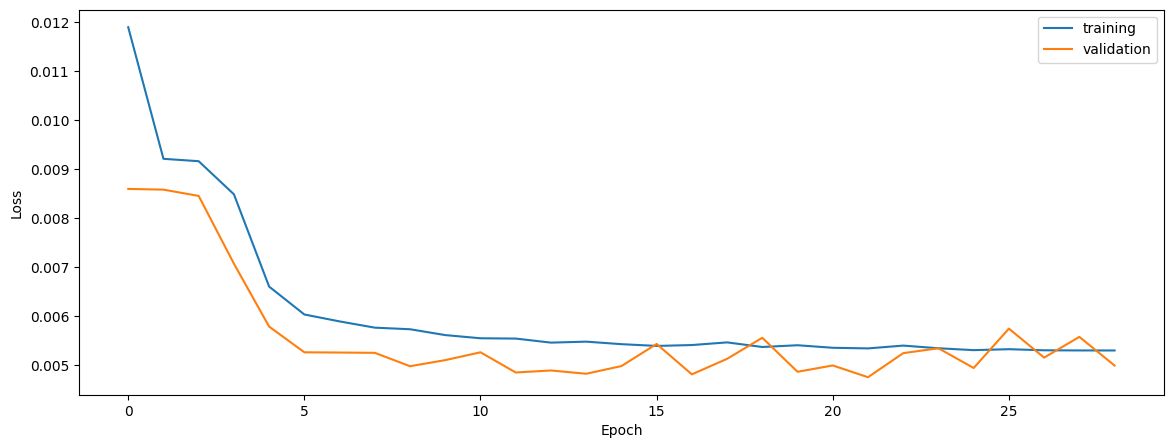

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


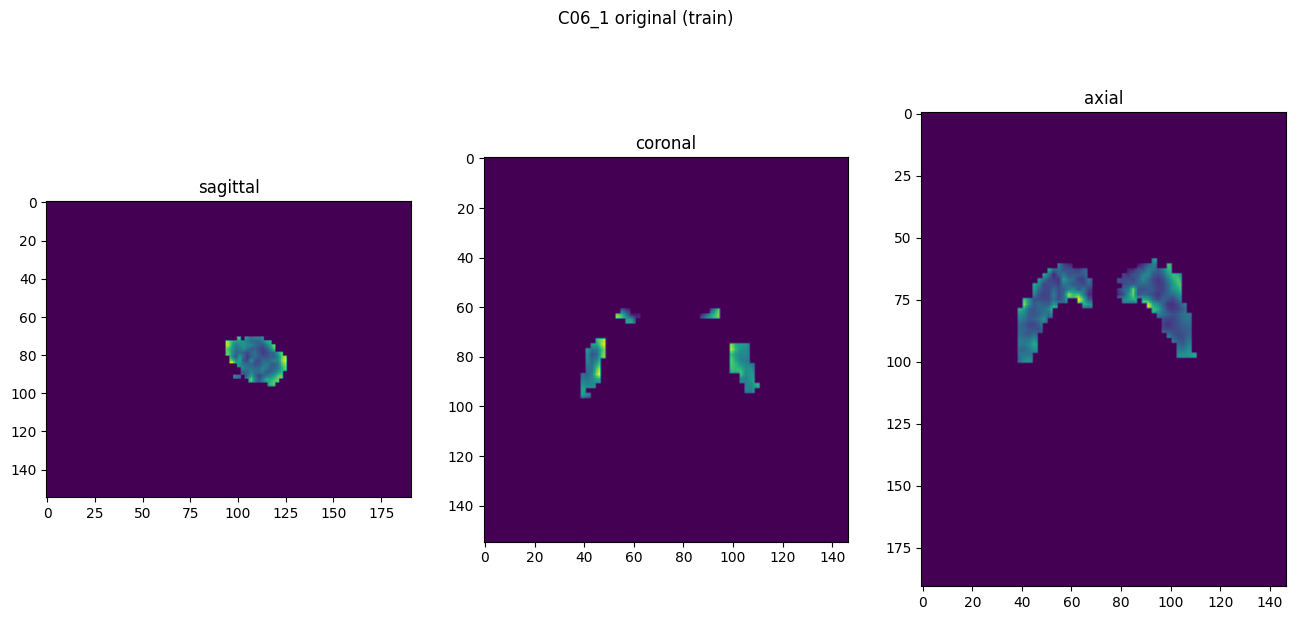

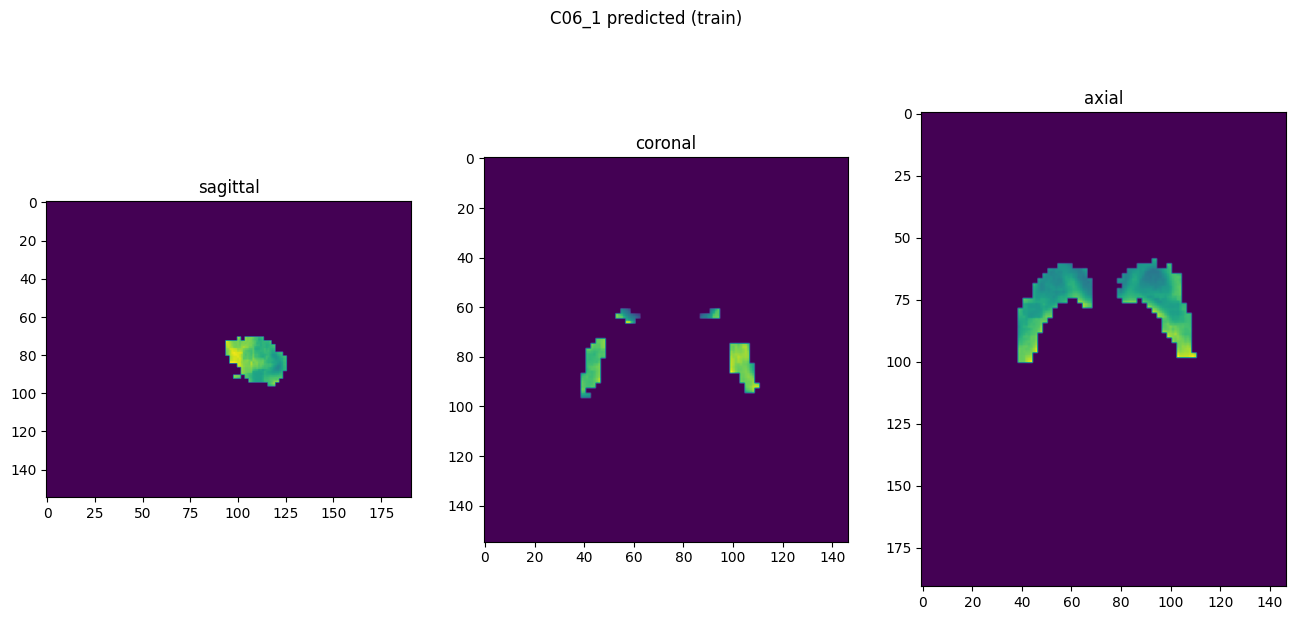

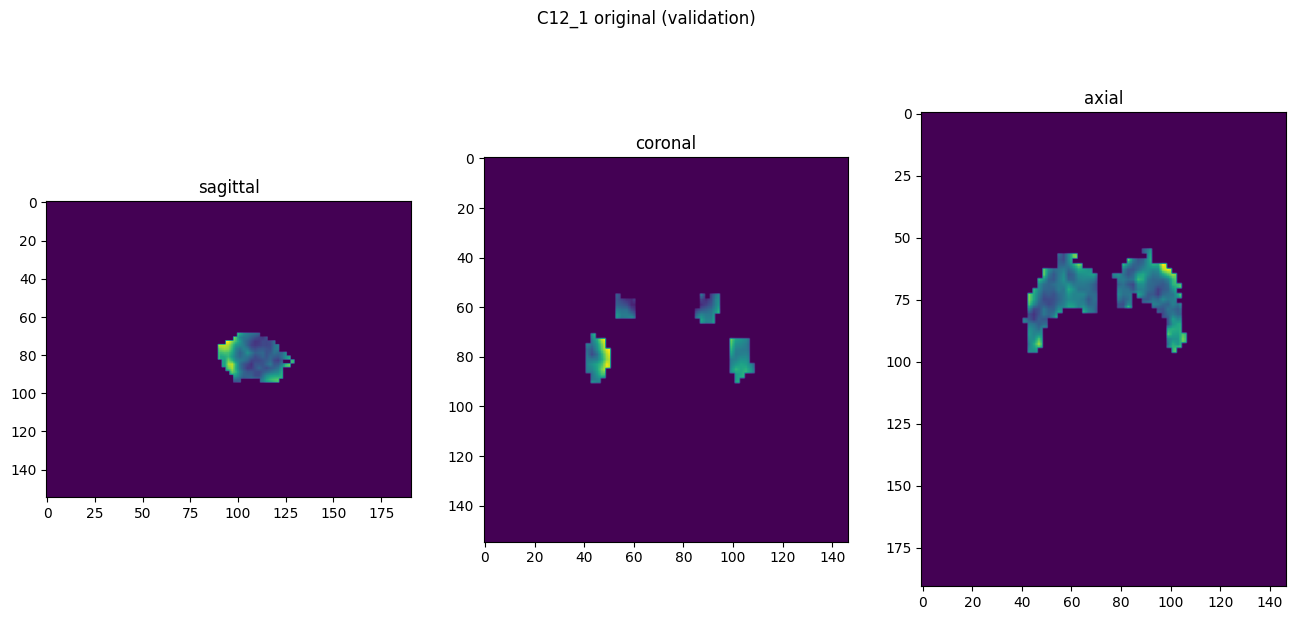

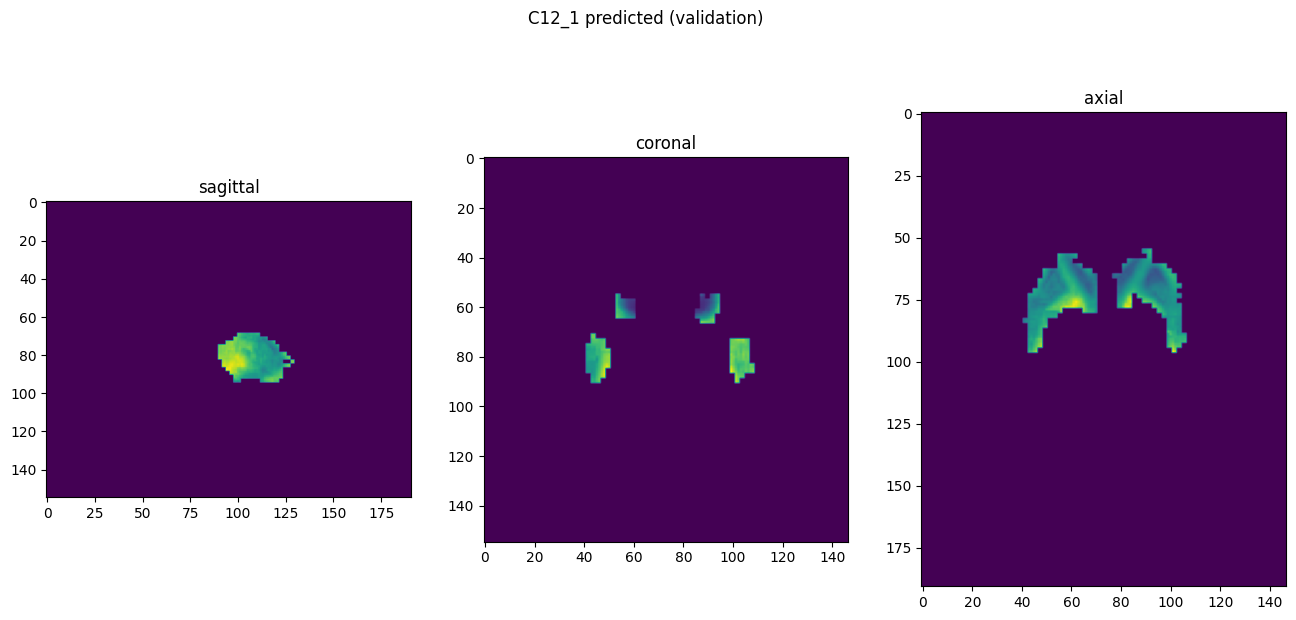

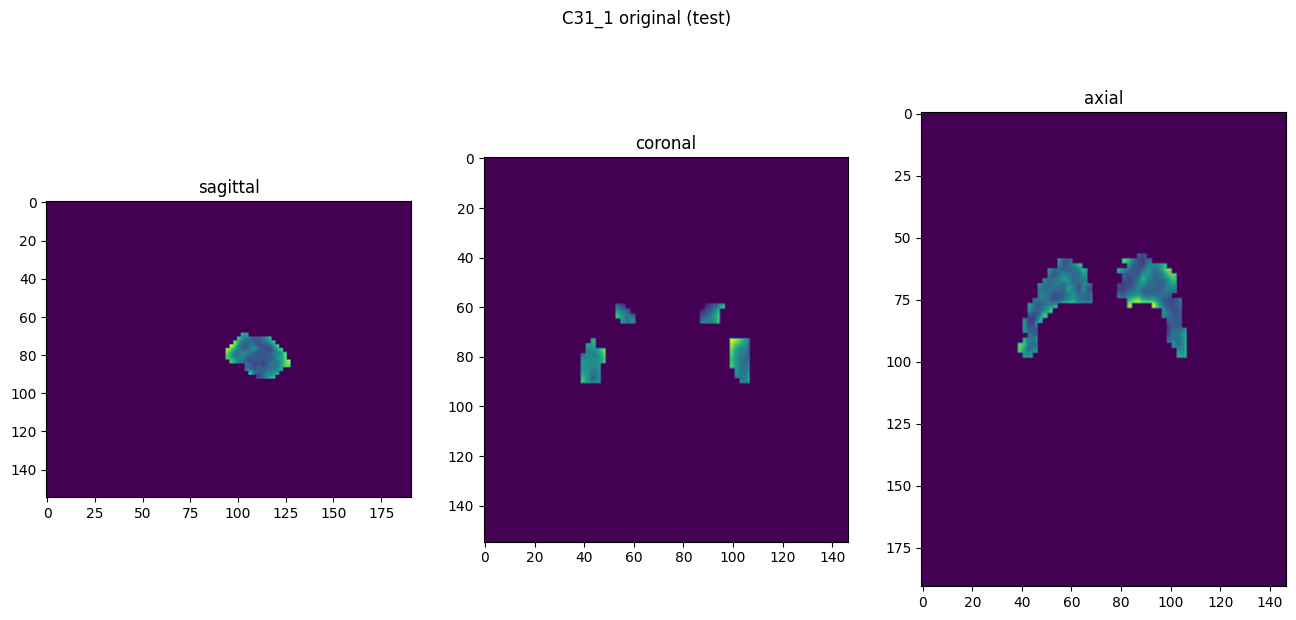

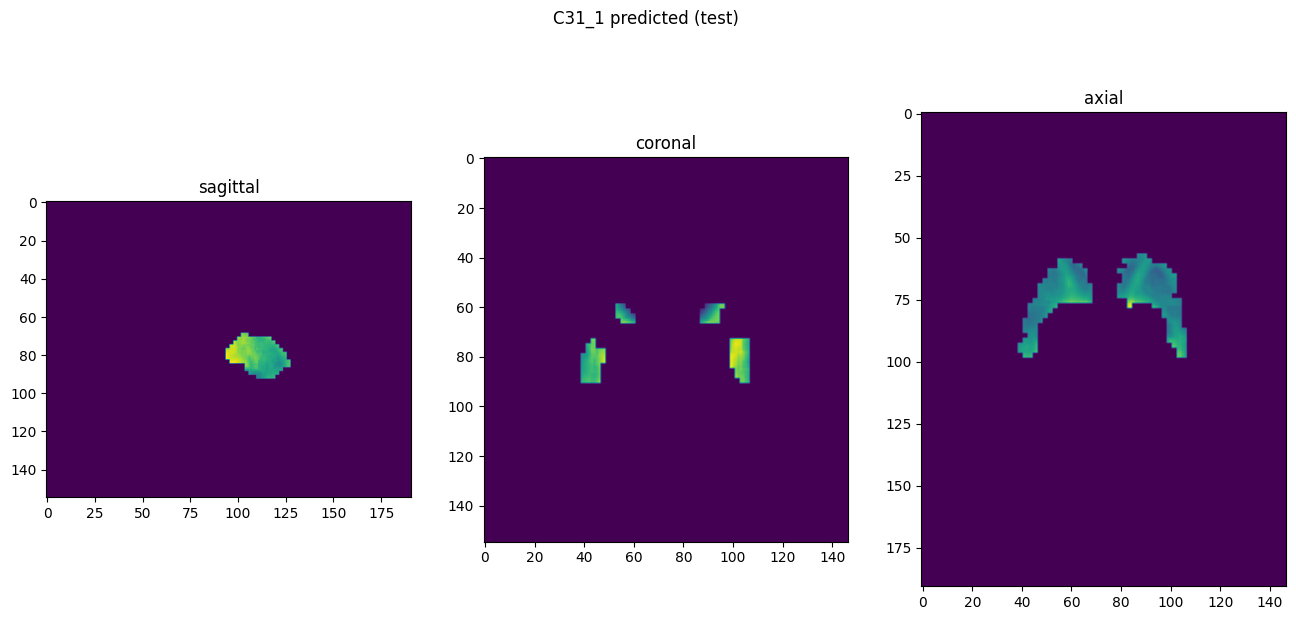

In [10]:
showResults(model, gen, threshold=None, background=False)